S(t) = α y(t)/I(t-L)   +   (1-α)(S(t-1) + b(t-1))   Smoothing Formula

b(t) = γ(S(t) - S(t-1)) + (1-γ)(b(t-1))             Trend Smoothing

I(t) = β y(t)/S(t) + (1-β)I(t-L)                    Seasonal Smoothing

F(t+m) = (S(t)+mb(t))I(t-L+m)                       Forecast


α  Smoothing Constant

β  Seasonal Constant

γ  Trend Constant

L  Period

Period is the number of periods in a year. In this input its 12.


Initial Values for S, b and I are calculated as follows:

b = 1/L ((y(L+1) - y(1)/L) + (y(L+2) - y(2)/L) . . . (y(L+L) - y(L)/L))


Average of number of cycle ( number of years in the input data )

A(p) = ∑yi/4  where i is 1 to 4, p = 1,2,3.... upto number of cycle.


I(1) = (y1/A1 + y5/A2 + y9/A3 + y13/A4 + y17/A5 + y21/A6...)/<number of cycle>

I(2) = (y2/A1 + y6/A2 + y10/A3 + y14/A4 + y18/A5 + y22/A6...)/<number of cycle>

I(3) = (y3/A1 + y7/A2 + y11/A3 + y15/A4 + y19/A5 + y23/A6...)/<number of cycle>

I(4) = (y4/A1 + y8/A2 + y12/A3 + y16/A4 + y20/A5 + y24/A6...)/<number of cycle>


Initial value of S = first observation of y

S and b are scalar values whereas I is a vector of m period which will be accessed by MOD to get the position of the cycle. 



This Holt Winters code is very sinmple and straightforward coding. I didn't use any class object in this code as my
objective is mainly on the understanding of the Exponential Smoothing techniques.  There are packages ready available 
to use to get the forecasting model and report. Purpose of my work is help someone to understand how the smoothing is 
done step by step. This code also doesn't have optimized alpha, beta and gamma constant values. 

This is my reference to concept: https://www.itl.nist.gov/div898/handbook/pmc/section4/pmc4.htm

As I am done with Holt Winters, next will be ARIMA model step by step coding. See you soon!!


Note: I will keep updating this repository with new and changed code for better optimization. 

           Month  Sales
Month                  
1960-01  1960-01   6550
1960-02  1960-02   8728
1960-03  1960-03  12026
1960-04  1960-04  14395
1960-05  1960-05  14587
...          ...    ...
1968-08  1968-08  16722
1968-09  1968-09  14385
1968-10  1968-10  21342
1968-11  1968-11  17180
1968-12  1968-12  14577

[108 rows x 2 columns]


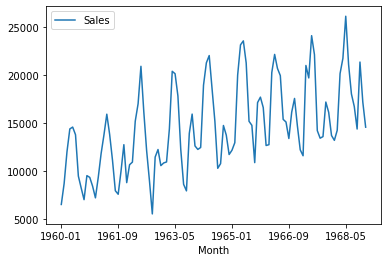

In [684]:
import pandas as pd
import numpy as np
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from matplotlib import pyplot as plt
from sklearn import model_selection as skl
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

path = 'monthly-car-sales.csv'
df = pd.read_csv(path, header=0)


df.index = df['Month']
df.drop('Unnamed: 0',axis =1 , inplace=True)


print(df)

df.plot()
plt.show()

In [685]:
df_new = df.copy()

print(df_new)
L = 12

b = 0

df_new['S'] = 0

df_new['b'] = 0


df_new['predict'] = 0.00

df_forecast = []
       
S_initial = 0

b_initial = 0

#Get the initial smoothing value

S_initial = df_new['Sales'][0]

#Get the initial trend value

for i in range(L):
    b += (df_new['Sales'][L+i] - df_new['Sales'][i])/L
    
b_initial = b/L


           Month  Sales
Month                  
1960-01  1960-01   6550
1960-02  1960-02   8728
1960-03  1960-03  12026
1960-04  1960-04  14395
1960-05  1960-05  14587
...          ...    ...
1968-08  1968-08  16722
1968-09  1968-09  14385
1968-10  1968-10  21342
1968-11  1968-11  17180
1968-12  1968-12  14577

[108 rows x 2 columns]


In [686]:
#Find the number of cycle in the input
num_cyc = 0
length = len(df_new)

start_year = df_new['Month'][0][:4]
end_year = df_new['Month'][len(df_new)-1][:4]

start_year = int(start_year)
end_year = int(end_year)

num_cyc = end_year - start_year


num_cyc += 1

Ap = []

#Get the initial value for I

#First compute the average for each cycle(year)

for i in range(1,num_cyc+1):
    if i == 1:
        Ap.extend((df_new.iloc[i-1:i+11,1:2].sum()/12).astype(int))
        x = i+11
    else:
        Ap.append((df_new.iloc[x:x+12,1:2].sum()/12).astype(int))
        x = x+12
        
       
    


In [687]:

#Compute intial Seaonal Index

I = []
x = 0
for i in range(L):
    seasonal = 0
    x = 0
    for j in range(num_cyc):        
        if j == 0:
            seasonal+= ((df_new['Sales'][i])/Ap[j])
        else:
            x = x+12
            seasonal+= df_new['Sales'][x]/Ap[j]
        
    I.extend(seasonal/num_cyc)

    
print(I)

[0.7420503570984492, 0.7658084564505011, 0.8017837602443794, 0.8276253292824927, 0.8297197071868058, 0.8210367654585077, 0.7742077845042568, 0.7606052363444733, 0.7474935580060129, 0.7747204707620834, 0.7727460832585382, 0.7628414210860576]


In [688]:
#To find the forecasting

def holt_winters_forecast(df_new,L,I,forecast_value):
    
    a=0.1
    g=0.2
    b=0.3
    y = 0.0
    m = 0
    
    for i in range(len(df_new)+ forecast_value):
 
        
        if i >= len(df_new):
                                
            m += 1
            
           #forecast formula F(t+m) = (S(t)+b(t))*I(t-L+m)
        
            df_forecast.append((df_new['S'][len(df_new)-1] + (m*df_new['b'][len(df_new)-1])) * (I[i%L]))
            
        elif i == 0:
            
            df_new['S'][i] = (a*(df_new['Sales'][i]/I[i])) + ((1-a)*(S_initial + b_initial))

            df_new['b'][i] = g*(df_new['S'][i] - S_initial) + (1-g) * ( b_initial)
               
            I[i] = b*(df_new['Sales'][i]/df_new['S'][i]) + (1-b)*I[i]
            
            df_new['predict'][i] = (df_new['S'][i] + df_new['b'][i]) * (I[i%L])
            
        else:
            
            df_new['S'][i] = (a*(df_new['Sales'][i]/I[i%L])) + ((1-a)*(df_new['S'][i-1] + df_new['b'][i-1]))

            df_new['b'][i] = g*(df_new['S'][i] - df_new['S'][i-1]) + (1-g) * (df_new['b'][i-1])

            I[i%L] = b*(df_new['Sales'][i]/df_new['S'][i]) + (1-b)*I[i%L]
            

            df_new['predict'][i] = (df_new['S'][i] + df_new['b'][i]) * (I[i%L])
    
    
    return df_new,df_forecast
    
holt_winters_forecast(df_new,L,I,forecast_value= 24)



(           Month  Sales      S    b       predict
 Month                                            
 1960-01  1960-01   6550   6828  100   5592.425971
 1960-02  1960-02   8728   7374  189   6739.777697
 1960-03  1960-03  12026   8306  337   8605.051485
 1960-04  1960-04  14395   9518  512  10361.561702
 1960-05  1960-05  14587  10785  663  11294.159398
 ...          ...    ...    ...  ...           ...
 1968-08  1968-08  16722  21784  194  15165.472707
 1968-09  1968-09  14385  22204  239  13683.850193
 1968-10  1968-10  21342  22901  330  19333.794104
 1968-11  1968-11  17180  23057  295  18284.931095
 1968-12  1968-12  14577  23147  254  15629.975943
 
 [108 rows x 5 columns],
 [14842.501704530168,
  15652.877087004996,
  23603.146354856275,
  25767.13215478362,
  28618.406304260898,
  25139.552210574897,
  19279.775283884617,
  17374.25777100975,
  15506.900234652121,
  21377.778362675042,
  20312.15302936323,
  17496.142038197104,
  16775.750078335044,
  17669.78553600906,
  2661

In [689]:
def forecast_time(df_forecast,df_new):

    df_new_forecast = df_forecast.copy()

    df_new_forecast = pd.DataFrame(df_new_forecast,columns = ['forecast'])

    df_new_forecast['Month'] = [0]*len(df_new_forecast['forecast'])

    df_new_forecast['Month'] = pd.to_datetime(df_new_forecast['Month'])
    
    df_new['Month'] = pd.to_datetime(df_new['Month'])


    temp_value = df_new['Month'][-1]

    temp_value = pd.to_datetime(temp_value)

    for i in range(len(df_forecast)):
        
        if i == 0:
            df_new_forecast['Month'][i] = temp_value + pd.DateOffset(months=1)
        else:
            df_new_forecast['Month'][i] = df_new_forecast['Month'][i-1]+pd.DateOffset(months=1)
            

    df_new_forecast = df_new_forecast.set_index('Month')
    
    df_new.reset_index(drop=True, inplace=True)
    
    df_new = df_new.set_index('Month')
    
            
    return df_new_forecast,df_new


df_new_forecast,df_new = forecast_time(df_forecast,df_new)

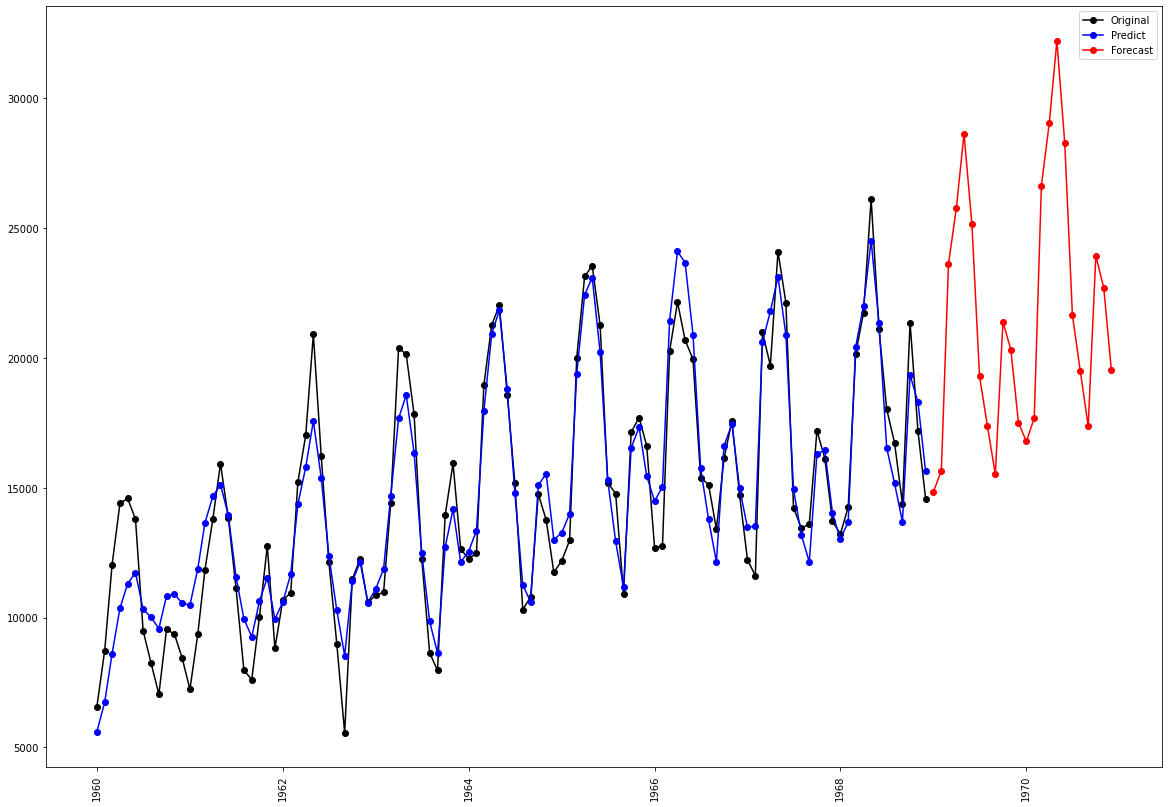

In [690]:
plt.figure(figsize=(20, 14))

x, = plt.plot(df_new['Sales'], marker='o', color='black')

y, = plt.plot(df_new['predict'], marker='o', color='blue')

z, = plt.plot(df_new_forecast['forecast'],marker='o',color='red')

plt.xticks(rotation = 'vertical')

plt.legend([x,y,z],['Original','Predict','Forecast'])

plt.show()

In [621]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as holt


sales_holt = holt(df_new['Sales'],trend = 'add', seasonal='add', seasonal_periods=12)

sales_fit = sales_holt.fit()

prediction = sales_fit.predict()

forecast = sales_fit.forecast(24)



In [573]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing as holt

df_holt = df_new.copy()

df_holt.index = pd.to_datetime(df_holt.index)

#df_holt.index = df_holt.index + '-01'

#df_holt.index = df_holt.astype(datetime)

sales_holt = holt(df_holt['Sales'],trend = 'add', seasonal='add', seasonal_periods=12)

sales_fit = sales_holt.fit()

prediction = sales_fit.predict()

forecast = sales_fit.forecast(24)

Month
1960-01-01     6550
1960-02-01     8728
1960-03-01    12026
1960-04-01    14395
1960-05-01    14587
              ...  
1968-08-01    16722
1968-09-01    14385
1968-10-01    21342
1968-11-01    17180
1968-12-01    14577
Name: Sales, Length: 108, dtype: int64
1969-01-01    14722.227711
1969-02-01    15243.968037
1969-03-01    22267.855695
1969-04-01    23507.184529
1969-05-01    26517.380538
1969-06-01    23118.920545
1969-07-01    18345.116657
1969-08-01    17060.445745
1969-09-01    15371.507062
1969-10-01    20512.143279
1969-11-01    18538.741987
1969-12-01    16956.779549
1970-01-01    15700.988305
1970-02-01    16222.728631
1970-03-01    23246.616288
1970-04-01    24485.945122
1970-05-01    27496.141132
1970-06-01    24097.681138
1970-07-01    19323.877251
1970-08-01    18039.206338
1970-09-01    16350.267656
1970-10-01    21490.903872
1970-11-01    19517.502580
1970-12-01    17935.540143
Freq: MS, dtype: float64


<AxesSubplot:xlabel='Month'>

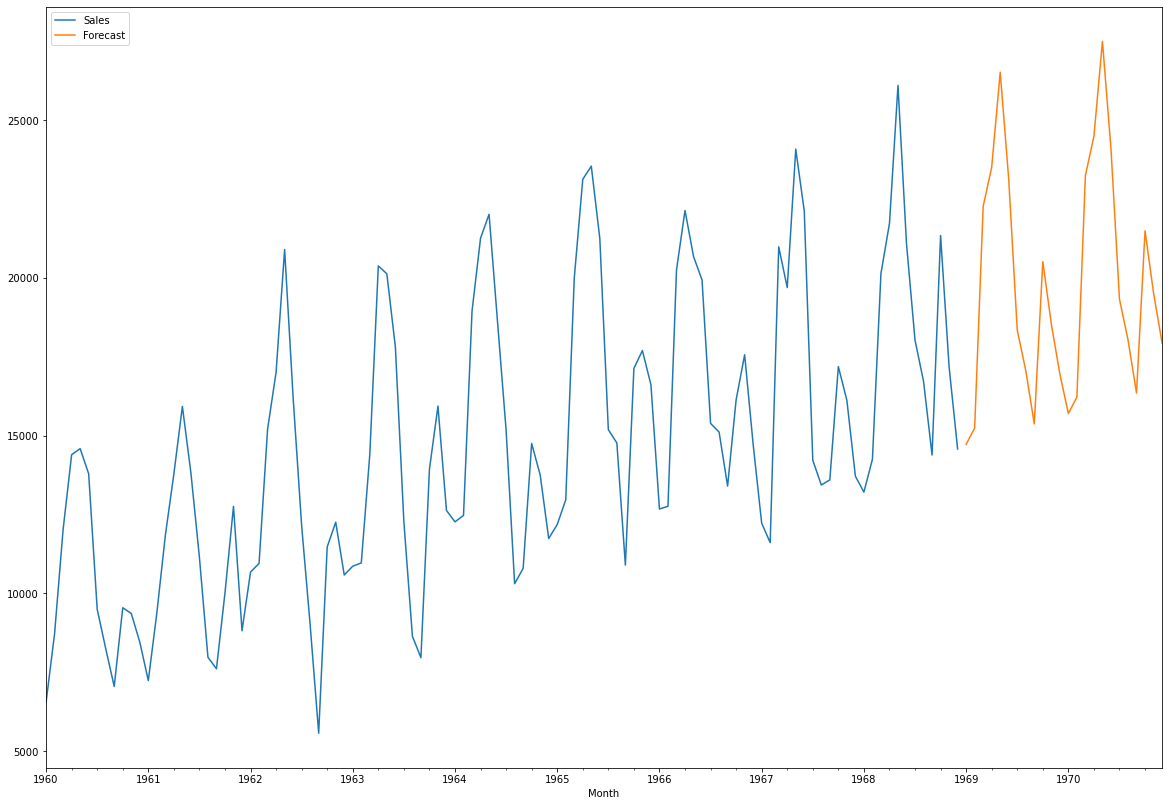

In [574]:
print(df_holt['Sales'])

print(forecast)

plt.figure(figsize=(20, 14))

df_holt['Sales'].plot(legend=True,label = 'Sales')

forecast.plot(legend=True,label = 'Forecast')